In [3]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from keras import backend as K
#!pip install segmentation-models
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

### added 100 gigabytes of memory limit

In [4]:
import pickle

with open("stage1/X_train", "rb") as f:
    X_train=pickle.load( f)
with open("stage1/X_val", "rb") as f:
    X_val=pickle.load( f)
with open("stage1/y_train", "rb") as f:
    y_train=pickle.load( f)
with open("stage1/y_val", "rb") as f:
    y_val=pickle.load(f)
with open("preds_test_best_submission", "rb") as f:
    preds_test=pickle.load(f)    
    
    

#with open("stage1/X_test", "rb") as f:
    #X_test=pickle.load(f)    
#preds_test=preds_test/8

In [5]:
im_width = 128
im_height = 128
im_chan = 1
test_ids=[]
path_test = r'C:\\Users\diego\OneDrive\Desktop\DS\seismic_segmentation\test'
for i in os.listdir(os.path.join(path_test,"images")):
    test_ids.append(i)    
# Get and resize test images
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    path = path_test
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_test[n] = x

print('Done!')

Getting and resizing test images ... 


<ipython-input-5-b4647d3bd7b7>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):


  0%|          | 0/18000 [00:00<?, ?it/s]

Done!


In [14]:
'''
def confident_images(X_test, preds_test,threshold=1900):
    #X_test=X_test.tolist()
    #preds_test=preds_test.tolist()
    confident_X_test1=[]
    confident_y_test1=[]
    def BinaryCrossEntropy(y_true, y_pred):
        y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
        term_0 = (1-y_true) * np.log(1-y_pred + 1e-7)
        term_1 = y_true * np.log(y_pred + 1e-7)
        return -np.mean(term_0+term_1, axis=0)
    for i,elem in enumerate(preds_test):
        confidence=BinaryCrossEntropy(X_test[i].flatten()
                                      ,preds_test[i].flatten())
        if confidence>=threshold:
            confident_X_test1.append(X_test[i].tolist())
            confident_y_test1.append(preds_test[i].tolist())
            print(confidence)
    return confident_X_test1,confident_y_test1
confident_X_test1,confident_y_test1=confident_images(X_test, preds_test,threshold=1900)'''

1964.0485
1922.512
1903.526
2010.0925
1920.6299
1902.6768
1927.9142
1947.8939
2065.3633
2166.0366
1936.2699
1964.1313
2134.8474
2248.5688
2057.1152
2188.3584
2377.1108
1985.593
2197.579
1996.3522
2277.9531
1998.0907
1992.3853
1911.9182
2081.4915
1905.1406
2201.7954
1981.4882
1931.0322
2024.8431
1987.8342
1951.114
1999.2773
2036.2864
1912.7717
2009.3131
2019.6176
1901.3691
2410.0906
1936.4698
1924.2555
2186.0605
1959.4359
2218.603
2056.8604
2114.5312
2152.178
1963.609
2020.0922
2001.8253
2372.855
2015.2717
2130.3257
1977.5077
1909.375
2220.405
1934.532
2098.9243
1941.5267
1997.811
1990.4098
1943.2976
2212.9426
2401.6855
2104.0837
2299.7139
1953.3185
2074.9688
1931.6338
2159.8433
1971.8037
1970.5349
2174.5742
2061.1978
2013.2908
2036.7319
2264.3188
2024.595
1913.6405
1904.5768
2180.9932
1982.8214
1953.7881
1918.2859
2000.2092
2080.2688
2076.1123
2170.3452
2533.3672
2002.0426
1986.0377
2080.8433
1904.1814
2788.3315
2230.643
1960.4246
2128.5044
2279.251
1942.4932
1943.0223
2100.0698
2197.1

1939.499
2046.543
2081.099
2132.2312
1959.7958
1935.7952
1966.4473
1905.5486
2005.6794
2103.1724
1905.2764
1917.0642
2255.586
1939.5195
2149.2212
2549.076
1904.5925
1905.153
1911.8999
2310.4617
1969.5774
2097.8428
1968.3596
2112.4282
1940.6653
1998.9657
1950.4794
2187.2102
1997.4924
1912.6011
2122.9536
2060.5972
2191.534
2487.6484
2380.2463
1904.4125
1923.6765
1946.1287
2147.4487
1991.6676
1954.7208
1928.197
2298.791
1948.783
2328.8154
1961.7574
1935.5183
1928.5826
1967.7664
2133.7693
1908.4651
1928.0527
2235.0396
1908.8503
2011.7891
2041.3372
1939.0067
2167.6162
2431.7266
1924.4875
2588.0908
1939.4099
2344.0635
1902.0148
2023.4893
2106.0044
1945.5006
2089.4841
2176.9824
1963.8613
2005.6611
2059.1318
2165.4414
1968.1436
2046.2953
2089.0083
2564.147
2081.293
2078.9312
1978.9613
2038.0767
1929.6305
2335.216
2110.6887
1978.8479
2142.128
1976.8867
2044.7899
1950.6788
1917.8295
2033.7334
2090.915
1943.6594
2095.3105
1913.6506
2006.748
1974.4683
1992.698
2096.068
2549.4578
2017.6475
2205.121

KeyboardInterrupt: 

In [36]:
y_true= np.where(preds_test >= 0.500, 1, 0)
y_true,preds_test

(array([[[[0],
          [0],
          [0],
          ...,
          [0],
          [0],
          [0]],
 
         [[0],
          [0],
          [0],
          ...,
          [0],
          [0],
          [0]],
 
         [[0],
          [0],
          [0],
          ...,
          [0],
          [0],
          [0]],
 
         ...,
 
         [[0],
          [0],
          [0],
          ...,
          [0],
          [0],
          [0]],
 
         [[0],
          [0],
          [0],
          ...,
          [0],
          [0],
          [0]],
 
         [[0],
          [0],
          [0],
          ...,
          [0],
          [0],
          [0]]],
 
 
        [[[0],
          [0],
          [0],
          ...,
          [0],
          [0],
          [0]],
 
         [[0],
          [0],
          [0],
          ...,
          [0],
          [0],
          [0]],
 
         [[0],
          [0],
          [0],
          ...,
          [0],
          [0],
          [0]],
 
         

In [46]:
preds_test.shape

(18000, 128, 128, 1)

In [42]:
thresholds=[y for y in range (950,2000,30)]
#thresholds=[1900,2000]
nimages=[]
def BinaryCrossEntropy(y_true, y_pred):
        y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
        term_0 = (1-y_true) * np.log(1-y_pred + 1e-7)
        term_1 = y_true * np.log(y_pred + 1e-7)
        return -np.mean(term_0+term_1, axis=0)
for j in thresholds:
    k=0
    for i,elem in enumerate(preds_test):
        confidence=BinaryCrossEntropy(X_test[i].flatten()
                                      ,y_true[i].flatten())
        #print(confidence)
        if confidence>=j:         
            k+=1
            #print(k)
    nimages.append(k)


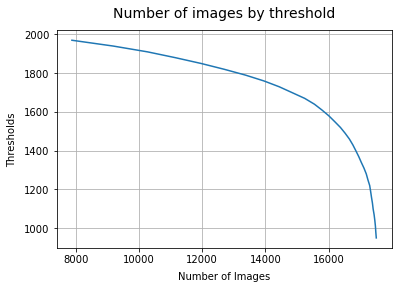

In [44]:
#nimages

plt.title('Number of images by threshold',fontsize=14,y=1.03 )
plt.grid( True )    
plt.plot(nimages,thresholds)
plt.xlabel('Number of Images',labelpad=7,fontsize=10)    
plt.ylabel('Thresholds',labelpad=7,fontsize=10)   
#plt.gca().set_ylim(0,1)
plt.savefig(os.path.join('plots/','Number_of_images_by_threshold_8_ensemble.png'), dpi=500, bbox_inches='tight',facecolor=(1,1,1))

In [47]:
thresholds_images = {thresholds[i]: nimages[i] for i in range(len(nimages))}
thresholds_images

{950: 17510,
 980: 17495,
 1010: 17483,
 1040: 17464,
 1070: 17441,
 1100: 17410,
 1130: 17388,
 1160: 17358,
 1190: 17331,
 1220: 17302,
 1250: 17245,
 1280: 17194,
 1310: 17121,
 1340: 17035,
 1370: 16954,
 1400: 16863,
 1430: 16769,
 1460: 16660,
 1490: 16525,
 1520: 16376,
 1550: 16195,
 1580: 16009,
 1610: 15791,
 1640: 15553,
 1670: 15246,
 1700: 14843,
 1730: 14438,
 1760: 13955,
 1790: 13374,
 1820: 12702,
 1850: 11972,
 1880: 11154,
 1910: 10274,
 1940: 9188,
 1970: 7880}

In [162]:
#confident_X_test1=np.array([])
confident_y_test1=np.array([])
threshold=1250
def BinaryCrossEntropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    term_0 = (1-y_true) * np.log(1-y_pred + 1e-7)
    term_1 = y_true * np.log(y_pred + 1e-7)
    return -np.mean(term_0+term_1, axis=0)
for i,elem in enumerate(preds_test):
    confidence=BinaryCrossEntropy(X_test[i].flatten()
                                  ,preds_test[i].flatten())
    if confidence>=threshold:
        #confident_X_test1=np.append(confident_X_test1,X_test[i])
        confident_y_test1=np.append(confident_y_test1,preds_test[i])
        print(confidence)
#confident_X_test1,confident_y_test1

1472.6359
1634.9846
1308.5106
1522.6438
1462.9843
1964.0485
1922.512
1368.7544
1903.526
1593.7562
1644.2834
1805.2688
2010.0925
1636.3228
1350.6238
1786.3478
1920.6299
1337.1305
1544.1599
1665.7168
1902.6768
1681.6045
1927.9142
1459.2766
1736.9176
1848.068
1661.8872
1402.6268
1602.0759
1535.445
1873.4133
1895.5964
1947.8939
1298.9797
1796.1855
1744.6359
1382.9524
1823.7787
1899.9674
1520.8308
1696.0917
1725.5372
1282.567
1790.5936
1692.255
1854.1204
1438.7705
1355.1785
2065.3633
1689.6796
1894.7637
1647.4738
1758.6621
2166.0366
1848.3523
1338.6316
1936.2699
1881.621
1497.3165
1366.8746
1562.4729
1408.8239
1964.1313
2134.8474
1642.0396
2248.5688
2057.1152
1499.8087
2188.3584
1505.8694
1767.2942
1421.3064
2377.1108
1985.593
1488.9026
1272.2872
2197.579
1472.5928
1854.7081
1755.1312
1996.3522
1569.9331
1844.1974
1266.2795
2277.9531
1466.4436
1998.0907
1992.3853
1517.6035
1424.9762
1641.6306
1451.6113
1266.1382
1784.699
1483.4814
1808.8999
1554.3936
1911.9182
2081.4915
1637.8042
1889.0004


1371.0596
1299.46
2192.6475
2253.6816
1358.4902
1616.5845
2133.721
1688.3126
1575.9238
2077.8486
1872.2507
1328.2161
1990.6909
1512.5674
2168.2224
1952.7954
1598.9241
1414.0061
1604.2751
2113.9863
1795.1255
2125.5703
1558.7332
1903.29
2003.5256
1409.8442
2203.1594
1559.2426
2213.7937
1353.941
1705.6316
1968.0817
1485.1771
1705.2322
1653.4675
1886.3794
1853.2046
1995.9612
1672.2179
1612.4146
1332.36
1853.3774
1892.2261
1694.043
2102.3452
2389.69
2038.8914
1948.3755
1730.5996
1483.9094
1964.1233
1867.9915
2013.7903
1471.1704
1451.5287
1693.9602
1911.3163
1744.3546
1473.5985
1966.5713
1729.7114
1925.1428
1618.7671
1463.7396
2038.1981
1825.4712
2051.5464
1270.1539
1939.99
2020.5873
1942.7551
1774.2812
1675.9055
1378.7834
1704.792
2067.6233
1972.9977
1698.751
1644.6938
1375.562
1312.225
1890.2328
2356.6553
1460.4441
1981.3325
1556.7576
1698.9546
1977.8223
1967.1986
1466.3806
1387.5282
1790.4084
1757.7363
1277.1709
1669.0719
1474.1606
1564.8167
2001.9076
1960.2771
1780.4117
2129.4717
1473.02

1735.0691
1504.9419
1777.6028
1983.0323
1401.3037
1316.7057
1625.8933
1370.4827
1366.6127
1539.2959
1814.713
1327.3728
2252.8193
1342.3221
1369.5723
1743.4624
2030.1942
1459.1968
1269.3724
1417.8186
1286.6758
1764.2869
1334.1244
1415.8911
2012.2648
2243.3547
2223.4565
1316.5674
1407.4996
1260.7681
1620.4299
1648.5544
1369.1709
1972.441
1566.0884
1528.9371
1645.6482
1606.3846
1834.5212
1324.5588
1886.02
1623.6714
1717.6249
2071.5972
1846.3143
1454.6265
2431.9258
2039.574
1928.0745
2040.2505
1297.2588
1436.6519
1821.085
2266.209
1467.8535
1860.6843
2336.5942
2022.9294
1685.5784
1313.1531
1498.8301
1779.2258
1799.2847
1499.5184
1950.7019
1820.3533
1276.0566
2050.1772
1718.7073
1830.5272
2089.4863
1986.7339
1485.4431
1805.6797
1468.5449
1371.5186
1343.7543
1413.7063
1626.5497
2068.9497
1401.8369
1386.6196
1781.78
2220.8271
1829.7244
1272.9406
1715.2103
1577.6023
1832.832
2306.3208
1864.944
1317.5322
1987.9595
1757.616
2287.2798
1412.0845
1585.332
2140.0146
2351.4565
1619.0198
1658.9146
159

1686.9965
2168.1294
1887.4203
1621.5251
2120.909
1859.6704
1739.2292
1878.9414
2109.933
1325.4982
1937.3478
1848.2375
1830.4321
1377.7773
1719.341
1830.1259
2007.1327
1387.374
1673.1204
1992.5781
1815.8967
1691.9503
1666.8744
1478.8163
1956.0696
1327.0286
1838.0159
1646.2798
1514.697
1756.0308
1386.0232
2334.9275
1839.281
1730.3844
1269.1436
1854.1199
1573.4578
2471.1255
1597.7578
1312.2043
1456.2769
2070.4712
1750.5769
1871.7778
1493.5527
1771.9993
1323.4318
1558.8525
1784.3684
1469.2045
1788.2711
1682.9111
1532.8291
1785.5027
1622.0054
1564.602
1301.4141
1539.481
1889.4238
1612.4465
2061.0361
1898.7876
1708.3694
2057.9053
1825.1094
1407.7239
1447.7043
1332.8552
2091.7114
1507.2123
1820.2495
1660.497
1501.0242
1814.9344
1496.7333
1549.3757
1917.8672
1290.5474
1496.2222
1634.8147
1432.6104
1765.6127
1755.634
1441.5684
2059.9216
1941.7852
1777.2449
1269.8046
1746.4575
1638.6564
1733.5605
1960.9858
1581.5969
1709.4089
1269.096
2001.3762
1310.1765
2083.0479
1293.5798
2214.085
1701.1449
19

1645.0898
1650.1404
1581.6194
1901.5813
1525.7812
1542.1024
1593.3196
1826.2473
1678.2102
1338.2705
1549.5474
1871.6887
1558.3896
2148.091
1457.5176
1683.2593
1578.3914
1426.1787
1711.9248
2110.1577
1753.4226
1852.8347
1306.7346
1628.7589
1643.786
1548.6254
1567.0818
1776.7703
1897.0112
1977.9368
1329.2983
1825.6542
1548.0986
2009.292
1518.847
1318.4302
1537.5975
1586.052
1757.8063
1575.6001
2099.5889
1624.4438
1413.3115
1408.4056
1466.1056
2257.4072
1949.1754
1364.3848
1306.3892
1888.4562
1694.3779
1772.4529
2200.391
1696.6372
2021.7587
1734.0924
2144.0107
1426.5653
2029.4651
1707.1248
1590.67
1758.9573
1373.8486
1659.8796
2090.7559
1815.343
1449.0903
1824.6519
1404.5835
1259.1652
1688.8955
1515.532
1528.62
1337.2942
1703.4612
1387.2217
1561.9275
1797.5446
1504.2567
1350.023
1889.7432
1484.5594
1818.3434
1311.7483
1820.5149
1322.7502
1266.3203
1866.7078
1321.6792
1949.9287
1820.8257
1816.2119
1891.004
1469.0681
1413.7524
1850.4712
1430.2671
1361.334
1867.6389
1914.5679
1777.6805
1917.

1828.322
1687.7363
2157.0679
1822.0917
1346.4124
1932.5945
1378.2125
1321.4392
1331.9049
2021.167
1817.527
1550.1487
1303.8126
1994.318
2019.6508
2050.976
2104.7195
1383.4246
1316.3567
1641.5801
1438.7418
1772.0386
2016.5491
1421.3237
1795.1919
1368.754
1761.1543
1744.0469
1860.9221
1406.9158
1255.4508
1784.0441
1735.4169
1448.717
1858.0676
1558.6279
1619.4323
1786.9187
1830.5514
1867.2666
1877.6765
1691.2771
1606.6211
1546.1791
1972.6987
1501.5851
1460.3489
2146.6592
1350.9653
2147.6865
1563.6823
1267.8625
1374.6145
1730.1406
1255.5408
1830.6353
1687.8535
1261.697
1780.6472
1712.3977
1728.4734
1920.9913
1892.3983
1628.9844
1689.2241
1260.4214
1729.1732
1304.218
1703.8252
2523.268
1901.933
1633.5388
2332.5444
1920.8633
1719.5753
1280.0358
1414.051
1516.2034
2001.6069
1567.0883
1710.4575
1408.8279
1451.4727
1817.3274
1491.9364
1334.1372
2005.3582
1333.3197
1375.1078
1781.697
1354.5808
1756.5212
1572.7186
1817.1003
2091.4253
2067.8052
2210.211
1907.2546
1790.9573
1572.4874
1321.3036
1529

1929.9587
1293.775
1257.2412
1513.0074
1944.028
1738.523
1886.8843
1827.4155
2010.1217
1886.0188
1942.3384
2003.2406
1489.0637
1608.0007
2437.9482
1910.802
1545.5726
1587.6849
2122.6353
1642.541
1612.0771
1757.6462
1781.1665
2049.163
1326.0513
1755.6683
1371.0637
1368.1384
1949.8779
1550.8438
2085.807
1891.642
1846.6687
1634.0383
1375.6418
1400.2839
1939.643
2065.7954
1643.9546
1347.7949
1932.1382
1432.0046
1251.1846
1825.207
1505.9833
1467.8356
1886.0266
2064.2886
1420.8735
1290.1189
1578.3728
2449.481
1761.8757
1513.1525
1394.2068
2301.0635
1854.6213
1298.2042
1835.9955
1463.0343
1724.2026
2048.8408
1700.733
1583.8262
1526.8611
1703.7898
1503.497
1266.0474
1646.2014
1764.0155
2117.3691
1695.1917
1792.6771
1892.5085
1405.7332
1857.2748
1458.5593
1636.6782
1502.1787
1970.5088
2201.835
1796.1737
2020.1626
1850.9926
2422.306
1418.5201
1760.5239
1888.7443
1464.0927
1844.7451
1879.7163
1816.8423
1935.4819
2110.0137
1367.3263
1820.9265
1863.8213
2007.479
1714.6128
1358.1206
1411.1343
2513.8

1628.2776
1419.7043
1891.1746
1580.9812
1728.1266
1529.4055
2065.457
1485.1165
2102.4504
2192.226
1910.6462
1791.5004
1515.2114
1961.8427
2111.344
2101.328
1911.1172
2149.5303
1278.2615
2131.4048
1867.9
1601.5701
1344.8774
1644.0186
1908.7549
1890.8525
1949.7231
1868.7234
1813.4015
1508.7291
2024.3948
1542.9238
2001.2399
1519.1616
1729.1199
1773.7592
1398.5737
1562.5653
2001.3782
1261.0896
1711.7136
1923.4915
1809.4875
2312.7524
2386.3909
2026.3018
1571.8221
1824.9453
2024.1287
1476.373
1288.3447
2026.36
1681.8855
1342.2974
1450.7816
1379.086
1529.5769
1941.5354
1335.227
1572.5183
1560.8494
1883.7894
1304.5059
1832.9564
1558.8118
1661.9513
1824.5262
1279.3031
1343.3848
1657.0864
1592.5608
2067.7783
1842.9126
1988.5654
1821.3315
2191.98
1829.568
1804.457
2097.0874
2000.1027
1554.1489
1266.7043
2019.5481
1314.7971
2058.9531
1287.3507
2865.4067
1589.7205
1853.1365
1819.6263
1523.7739
1732.6301
1682.541
1357.4164
1809.3826
1600.0938
1369.1472
1793.4468
1255.7617
1794.3525
1824.9658
2023.48

1288.8151
1966.9685
1793.6128
1731.8137
1818.1987
1864.9532
1697.5459
1372.5515
1264.1284
1361.4148
2143.2642
1527.9553
1392.1947
2276.195
1478.0903
1739.9746
1444.1615
1797.935
1293.3936
1418.4844
1592.6257
1819.5757
1290.5356
2004.902
1830.7847
1930.7595
1270.2368
1992.2517
2090.4722
1558.0592
1796.9138
2026.1083
1439.2456
1599.0186
1780.5728
1253.2509
1723.382
1462.5862
2440.9558
1401.7654
1826.9753
1849.2847
1844.546
1892.8367
1822.0929
2047.7375
2042.3303
1827.3373
1884.2068
1285.8435
1745.323
2245.2249
1448.7527
1753.7568
1864.2568
2336.9578
1704.3362
1896.0549
1767.4514
1496.0463
1777.147
1779.1278
2045.9758
1380.0969
1332.5957
1747.1864
1780.1226
1892.5771
1409.1194
1807.1367
1676.3212
1396.3672
1345.3202
1992.7448
1820.3549
1918.3174
1644.106
1854.8282
1408.2239
1912.487
1255.1287
1638.3815
1856.5779
1695.8707
1706.4934
2071.499
1719.7339
1712.7661
1771.109
1908.2911
1722.6843
1304.2144
1320.1646
1890.8645
2042.8097
1765.4154
1326.171
1296.864
1772.834
1860.9355
1608.5282
1810

1916.0073
1784.2054
1900.2067
1944.9155
1610.2755
1475.0714
1921.1486
1262.947
1416.7823
2097.695
1869.8323
2061.5786
1456.3303
1852.9749
1596.4384
1739.1821
1822.4592
1445.3564
2006.2961
1838.8733
1428.9885
2161.0352
1293.9795
1943.2053
1293.9939
1759.2091
1902.9163
1369.8792
1343.3055
1806.1863
1675.4991
1768.9277
1842.4631
2086.4856
1730.7068
1771.7434
1454.2942
1895.2429
1543.6836
1563.6125
1342.8796
1812.3857
1830.5085
1364.5619
1695.2935
1814.4193
1350.5691
1910.5056
1321.801
1727.4587
1351.6564
1922.793
2144.3298
1551.5002
1324.889
1935.994
1538.0966
1936.6648
2016.4149
1625.675
1761.5471
1982.287
1289.7168
1708.5374
1323.9951
1323.0187
1722.6898
1331.4182
1817.3416
1680.2097
1747.3666
2244.9563
1919.494
1809.3794
2214.683
1724.2949
1452.0923
1497.9902
1846.4595
1461.4949
1880.937
2388.3745
1803.1895
1986.9803
1689.5107
1759.3567
1725.2565
1878.6299
1440.7078
2019.3999
1590.4932
1937.492
1804.5317
1319.4636
1418.9188
1632.0706
2027.449
1300.1486
1302.1909
1815.7454
1312.618
1280

1984.5708
1793.8389
1459.6759
1689.8419
1553.3567
1735.0221
2125.6885
1565.3545
1563.3633
1958.8237
1905.693
2211.2952
1799.5376
1948.372
1337.437
1684.9465
1813.1654
1277.75
1706.2148
1444.0819
1699.3928
1624.5123
1798.0607
2044.5181
1722.4373
1563.4795
1610.9888
1433.6626
1675.1285
1738.4001
1422.6135
1666.605
1985.3403
1933.136
1320.6461
2167.3772
1318.2241
1510.3859
1581.8282
2215.519
1717.141
1563.7915
1308.5999
1623.793
1672.2766
1758.6755
2250.4995
1412.0745
1803.2073
2020.0347
1678.0056
2012.3145
1926.7328
1621.0968
1725.422
1824.3853
1323.8877
1492.5239
1898.198
1358.7266
2295.2173
1626.7081
1319.4722
1324.1575
1649.3928
1824.1664
1328.8999
2208.1475
2135.8057
1659.5945
1381.9431
2013.966
1728.5063
1254.5411
1590.1055
2074.7822
1914.6562
1725.0416
1471.6223
1296.1366
1431.4028
1347.3533
1865.0536
1763.9347
1852.9388
1302.0261
1649.2177
2153.6558
1986.5856
2034.4724
1451.1123
1502.1086
1675.2899
1495.9067
1260.4392
1883.7054
1388.3145
1442.5599
1558.3464
1742.2578
1737.1427
146

1406.468
1595.9792
1782.1025
1529.1008
1571.4321
1692.0935
1811.818
1690.3309
1568.7078
1319.938
2221.7578
1975.8643
1665.7786
1931.2891
2009.3677
1451.4788
1818.2804
1428.1267
2162.2742
2096.2424
1887.6477
1900.7018
1908.0869
1759.2119
1667.04
1700.7717
2010.2661
1505.479
1739.5651
1913.5652
2457.2498
1330.4885
1637.8118
2169.6858
2117.2712
1939.3472
1906.6339
1591.3134
1675.7528
1780.6708
1468.4989
1718.5332
1467.272
1326.1128
1871.4783
1655.2981
1417.5259
1314.7969
1410.9406
2005.8767
1337.9912
1921.7266
1723.5769
1438.5874
1411.4847
1767.2794
1415.0332
1732.9745
1792.7446
1368.2631
1451.0708
1673.9604
1339.6465
1675.0635
2038.0256
1564.7137
1723.0437
2110.2295
2199.5005
1951.7443
1831.4482
1339.7936
1897.0464
1713.435
1817.2484
1422.8638
1853.5642
1639.2749
2001.646
1669.1349
1774.158
1829.9612
1635.301
1825.0624
1919.49
1746.6488
2149.5125
1787.0325
1797.1165
1400.2676
1507.4564
1703.487
1848.3745
1693.3129
1665.8645
1864.2927
1490.6057
1898.8943
1804.9995
1795.0892
1427.768
2144.

2032.6582
1776.5491
1463.9172
1815.2954
1272.3042
1714.5259
1641.1006
1932.387
1577.3457
1535.9512
1900.2456
1782.3627
1401.5193
1255.783
1509.5593
1785.6686
2098.99
1286.3406
1812.3369
1531.3932
2031.9719
1744.2931
1650.892
1986.5951
1766.8312
1557.7136
2238.75
1620.7822
1254.713
1778.5786
1836.5256
1405.2916
1615.355
1746.8464
1636.6243
1805.7344
1649.8245
1866.2297
1342.256
1251.1268
1657.6561
1942.897
1557.2429
1470.6001
1250.8213
1564.2794
1775.7625
1664.3046
1617.655
1397.5906
1710.4957
1883.7605
1962.2842
1517.1091
1707.4297
2107.442
1836.677
1969.1187
1285.8855
1347.9021
1544.4003
1631.0758
1824.7776
1775.3301
1259.4973
1804.3237
1884.2948
1382.6204
1723.8369
1641.6477
1736.345
1333.29
1942.1061
2048.6401
1436.3848
1790.5901
1866.3308
1297.6826
1577.5898
1723.3748
1961.0404
2057.2275
1400.5837
1653.4307
1753.087
1831.8813
1336.7225
1896.7534
1606.5923
1591.6782
1933.9355
1476.4594
1310.2673
1780.523
2086.121
1295.8608
1944.7362
1739.0802
1875.8663
1759.5046
1565.8794
1333.8174


1468.126
1374.282
1816.6345
1521.8818
1727.1791
1424.7781
1533.029
1763.57
1619.29
1459.3833
1777.7668
1809.9578
1721.6208
1722.0427
2107.023
1308.0275
1900.1775
1678.3208
1766.0544
1659.849
1461.9131
2005.8671
1811.1917
2123.728
1486.1003
2060.7634
1301.1567
1284.1733
1252.5942
1659.6035
2077.6602
1969.828
1438.8453
1733.8228
1995.6489
1893.5895
1340.7812
2173.3813
1952.2065
1975.7429
1298.2025
1765.7288
2065.212
1261.3845
2040.4327
1919.7933
1265.1431
1939.2308
1315.2235
1574.2925
1361.6085
1654.0
1819.5392
1546.6543
1338.9585
1860.8121
1839.536
1481.3881
1611.328
1721.3455
1881.8809
1789.2925
1830.0972
1979.3977
1894.6052
1939.6045
1556.3118
2266.1133
2654.786
1917.3833
1773.3771
1938.6793
1406.3646
1781.2722
1711.5974
1646.7526
1588.1797
1428.0508
1759.0266
1991.9937
1777.0287
1726.7136
1820.433
1359.9868
2141.831
1979.8806
1659.1365
2005.784
1423.2206
1427.6031
2376.5413
1517.9741
1876.0317
1483.8938
1577.2065
1388.8359
1263.5032
1595.1565
1917.6226
1928.2958
1273.002
1412.5697
19

1970.2341
1552.313
1773.7533
1835.1257
1815.8545
1358.4796
1495.043
1585.4613
1566.662
1998.56
1348.335
1334.0967
1957.9794
1709.7415
1261.5637
1396.8489
2294.1172
1281.3827
1965.6262
1889.9216
1491.4995
1278.5243
1379.3323
1386.2491
1418.2161
1726.1271
1858.0638
1522.6694
1793.0515
1261.7906
1810.6489
1600.1218
1682.1879
1787.8652
2252.7815
1974.4558
1802.4131
1433.6984
1507.1738
1425.7264
1600.4375
1297.4634
1402.1311
1570.135
2072.6265
1851.2292
1337.2017
1937.551
1659.8658
2539.715
1544.8705
1273.2239
1651.4707
2092.9487
1359.0889
2144.3042
1253.1439
1808.5938
1250.1489
1572.2126
1344.5253
1995.0754
1893.1915
1334.5204
1960.3823
1468.1849
1277.4059
1913.2852
1796.4653
2047.3696
1327.5315
1778.8954
1427.2427
1538.6838
1469.0167
1492.8516
1485.4348
1643.2235
1474.2983
1725.6714
1760.5332
1397.2236
2134.7295
1695.5693
1532.2246
1538.7175
2082.8477
1558.8286
1553.3602
1658.4874
1411.3394
1781.3206
1586.0114
1765.8984
1887.6118
1533.3816
1825.9934
1482.3495
1579.2266
1702.0435
1829.8352

1522.2671
1885.3798
1393.8215
1910.3794
1621.9451
1706.6721
1855.3928
1299.4043
2371.2397
1648.0564
1337.9236
1498.8533
1786.3467
2601.2356
2018.939
1933.2959
1778.8975
1826.7891
1830.7766
1796.9039
1253.4954
1697.605
1974.1951
1889.6635
1319.7527
1780.177
1585.7695
1379.8623
2544.7104
2132.957
1417.6001
1799.6877
1338.8655
1818.3303
1886.1599
1277.4438
1517.5704
1779.8301
1643.292
1349.9846
1764.2644
2128.4922
2020.4829
1691.1494
2002.2632
1368.3129
1552.1865
1835.1512
1587.3398
1660.116
1671.135
1304.4343
1369.1936
1359.9513
1831.0559
2061.9375
1587.7496
1503.4045
2425.2676
1372.4219
1434.8215
2210.1328
1839.5632
1727.0277
1833.4393
1712.1003
1903.9648
2105.505
1311.5044
1932.0945
1343.3488
1410.738
1883.0002
1773.3958
1706.5833
1625.3135
1411.325
1474.5107
2198.8135
1902.3608
1446.8655
1943.1672
1264.7999
1509.103
1514.9172
1472.8049
1883.6096
1510.0198
1621.9932
1543.8406
1697.5859
1350.2349
1924.9636
1669.209
2023.3335
1811.0198
1961.9591
1741.9209
1325.0792
1413.6606
1779.5862
13

1315.3273
1341.4673
1839.7617
2237.1792
1600.1909
1555.7925
1404.2007
1747.21
1872.1409
1327.8584
1307.8923
1893.6128
1835.7402
1297.9833
1937.3628
1752.2489
2077.149
1696.5569
1566.391
1728.523
1499.9857
1742.1594
1445.3239
1958.4524
1264.7375
1504.2314
1623.3748
1354.8019
1595.2638
1660.5232
1658.0465
1921.9847
1608.0371
1269.2959
1501.3663
1392.8562
1758.2544
1946.901
1677.04
1445.0367
1902.1077
1905.0684
1556.7969
1593.3274
1279.376
2033.5237
1335.9421
1721.3872
2342.1968
1699.7314
1791.5394
1889.7073
1478.9443
1732.0173
2102.0352
1731.0599
1349.8539
1665.8876
2097.0867
1636.5483
1509.792
1543.6349
1273.3932
1270.08
1829.0405
1470.03
1936.5692
1569.8204
1422.703
1293.8213
1917.7224
1599.7292
1728.766
1562.1682
1722.4424
1875.5892
1469.7993
1698.3455
1618.7986
1659.6415
1260.2319
1662.4362
1301.8142
1353.7456
1799.7393
1636.4781
1516.8938
1332.995
1651.333
1363.8287
1413.8728
1612.2893
1466.4578
2104.7178
1962.4131
1904.5571
1289.6052
2076.9346
1783.3961
1413.4601
1592.2158
1253.371

1626.3083
1313.948
1300.9512
1327.881
1295.0919
1920.2112
1795.4968
1981.8776
1544.9305
1981.3257
1975.8312
1746.5181
1639.3779
1793.179
2120.9849
1595.8547
1686.4014
1678.864
1825.8835
1548.8542
1925.5769
1654.4362
1569.8774
1668.7052
2055.1084
1534.0552
1918.0769
1301.6086
1411.9338
1305.4231
1280.8975
1854.7343
1363.7482
1527.7955
1392.2812
1396.138
1829.6492
1403.9155
2015.0779
1750.9604
1560.5217
1300.2573
1779.5099
1900.8046
1885.7732
1773.9917
1662.1425
1544.3965
1418.9512
1577.5056
1861.7437
1748.9939
2416.2058
1808.3954
1843.8826
1489.3828
1744.4521
1880.4583
1826.7274
1854.6267
2168.2764
1790.7866
1840.5635
1789.004
2009.8115
1983.9165
2054.4692
2804.2876
1545.0117
1959.2192
1963.4723
1930.7699
1830.7614
1267.3223
2236.1858
1676.0303
1376.199
1422.3314
1434.283
1841.7026
1532.0603
1499.0636
2432.4514
1659.4988
1575.0779
1388.102
1812.908
1311.3271
1969.1564
2337.2566
1589.7681
1581.0828
1643.3241
1427.508
1899.573
1395.221
1935.6907
1657.8444
1801.7971
1695.7809
1849.9506
178

In [163]:
confident_X_test1=np.array([])
#confident_y_test1=np.array([])
threshold=1250
def BinaryCrossEntropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    term_0 = (1-y_true) * np.log(1-y_pred + 1e-7)
    term_1 = y_true * np.log(y_pred + 1e-7)
    return -np.mean(term_0+term_1, axis=0)
for i,elem in enumerate(preds_test):
    confidence=BinaryCrossEntropy(X_test[i].flatten()
                                  ,preds_test[i].flatten())
    if confidence>=threshold:
        confident_X_test1=np.append(confident_X_test1,X_test[i])
        #confident_y_test1=np.append(confident_y_test1,preds_test[i])
        #print(confidence)

In [164]:
#confident_X_test1_1250=pred_test.reshape((-1,128,128,1))
#confident_y_test1_1250=confident_y_test1.reshape((-1,128,128,1))
#with open("confident_X_test1_1250", "wb") as f:
  #  pickle.dump(confident_X_test1_1250, f)
#with open("confident_y_test1_1250", "wb") as f:
   # pickle.dump(confident_y_test1_1250, f)

In [6]:
#[confident_y_test1_1750 >= 0.500]= True
#confident_y_test1_1750[confident_y_test1_1750 < 0.500]= False
pseudolabels_ensemble = np.where(preds_test >= 0.500, True, False)
#pseudolabels

In [167]:
#confident_X_test1_1250=confident_X_test1_1250.astype(np.int32)

In [7]:
#!pip install albumentations
from albumentations import (HorizontalFlip, ShiftScaleRotate, RandomContrast, RandomBrightness, Compose,Rotate)
import albumentations as A
import cv2

transform = A.Compose([
        HorizontalFlip(p=0.5),
        #Rotate(limit=15,p=0.5)
        #RandomBrightness(p=0.2, limit=0.2),
        #RandomContrast(p=0.1, limit=0.2),
        #ShiftScaleRotate(shift_limit=0.07, scale_limit=0.1, rotate_limit=15, p=0.5)
    ])

In [24]:

X_train_round2=np.concatenate((X_train,X_val,X_test))
y_train_round2=np.concatenate((y_train,y_val,pseudolabels_ensemble))

from sklearn.model_selection import train_test_split

X_train2,X_val2,y_train2,y_val2 = train_test_split(X_train_round2,y_train_round2, test_size=0.1)


transformed2 = transform(image=np.squeeze(X_train2), 
                        mask=np.squeeze(y_train2))

In [51]:
with open("X_train2", "wb") as f:
    pickle.dump(X_train2, f)
with open("X_val2", "wb") as f:
    pickle.dump(X_val2, f)
with open("y_train2", "wb") as f:
    pickle.dump(y_train2, f)
with open("y_val2", "wb") as f:
    pickle.dump(y_val2, f)

In [84]:
#np.concatenate((X_train,X_val,confident_X_test1_1700)).shape

(11355, 128, 128, 1)

In [85]:
#np.concatenate((y_train,y_val,pseudolabels_1700)).shape

(11355, 128, 128, 1)

In [52]:
#!pip install segmentation-models

In [9]:
def Intersection_over_Union(y_true, y_pred, threshold=0.5):
    y_pred = K.squeeze(tf.cast(y_pred > threshold,tf.int32), -1)
    y_true = K.cast(y_true[..., 0], K.floatx())
    y_pred = K.cast(y_pred, K.floatx())
    truth_areas = K.sum(y_true, axis=[1, 2])
    pred_areas = K.sum(y_pred, axis=[1, 2])
    intersection = K.sum(y_true * y_pred, axis=[1, 2])
    union = K.clip(truth_areas + pred_areas - intersection, 1e-9, 128 * 128)
    check = K.map_fn(lambda x: K.equal(x, 0), truth_areas + pred_areas, dtype=tf.bool) #images with no predicted and true salt bodies
    p = intersection / union #ratio for each image
    iou = K.switch(check, p + 1., p) # put 1 for images where no salt bodies were found 

    prec = K.map_fn(lambda x: K.mean(K.greater(x, np.arange(0.5, 1.0, 0.05))), iou, dtype=tf.float32) 
    #does each image have a iou greater than threshold? if so, the image iou is used to calculate the mean
    prec_iou = K.mean(prec)
    return prec_iou

In [25]:
# tf.float32
#tf.keras.clear_session()
tf.random.set_seed(50)
#
#import keras
#from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
import segmentation_models as sm
sm.set_framework('tf.keras')

sm.framework()



#reduce_lr = ReduceLROnPlateau(factor=0.1, patience=4, min_lr=0.00001, verbose=1)
N=1
#epochs = 100
#batch_size = 32
backbone='resnet34'
base_model = sm.Unet(backbone, encoder_weights='imagenet')# classes=1, activation='sigmoid')
inp = Input(shape=(None, None, N))
s = Lambda(lambda x: x / 255)(inp)
l1 = tf.keras.layers.Conv2D(3, (1, 1))(s) # map N channels data to 3 channels
out = base_model(l1)

model2 = Model(inp, out, name=base_model.name)

checkpoint=r"models/checkpoint"
if  os.path.exists(os.path.join(os.getcwd(),checkpoint))==False:
    if  os.path.exists(os.path.join(os.getcwd(),'models'))==False:
        os.mkdir('models/')
    os.mkdir(checkpoint)

from tensorflow.keras.optimizers import schedules
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.000054,
    decay_steps=5200,
    decay_rate=0.91
    )


opt = Adam(
    learning_rate=lr_schedule, # add exponential decay
    epsilon=1e-08)


model2.compile(optimizer=opt, loss='binary_crossentropy', metrics=[Intersection_over_Union])# metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

# summarize the model

model2.summary()

earlystopper = tf.keras.callbacks.EarlyStopping(patience=5, verbose=1,restore_best_weights=True
                                                ,monitor='val_Intersection_over_Union', mode='max')



history2=model2.fit( np.expand_dims(transformed2['image'],axis=3),  np.expand_dims(transformed2['mask'],axis=3),validation_data = (X_val2,y_val2), batch_size=15, epochs=25, 
                    callbacks=[earlystopper])

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, None, None, 1)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 3)     6         
_________________________________________________________________
model_5 (Functional)         (None, None, None, 1)     24456154  
Total params: 24,456,160
Trainable params: 24,438,810
Non-trainable params: 17,350
_________________________________________________________________
Epoch 1/25
1320/1320 [==============================] - 156s 113ms/step - loss: 0.1980 - Intersection_over_Union: 0.6259 - val_loss: 0.1266 - val_Intersection_over_Union: 0.7828
Epoch 2/25
1320/1320 [==============================] - 151s 1

In [99]:
!pip install Pillow==9.0.0

  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.2.0
    Uninstalling Pillow-9.2.0:
      Successfully uninstalled Pillow-9.2.0


69/69 [==============================] - 6s 59ms/step - loss: 0.0648 - Intersection_over_Union: 0.8876
Accuracy: 88.762087 Loss: 0.064753


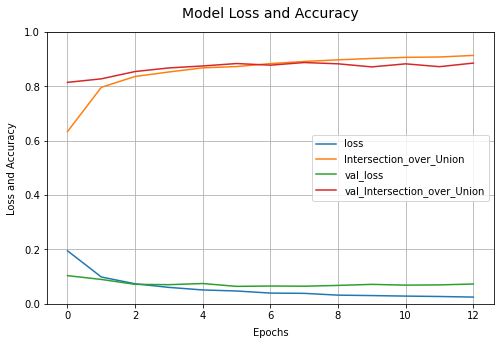

In [15]:
#save the model
name='CNN_Unet_onlyflip_exponentialdecay__1loss_3round_ensemble'
#os.mkdir('models/')
if  os.path.exists(os.path.join(os.getcwd(),'models/'))==False:
    os.mkdir('models/')
model.save(os.path.join('models/',name+'.h5'))
model.save_weights(os.path.join('models/',name+'_weights.h5'))
#plt.gca().set_xlim(0,33)
   
    
if  os.path.exists(os.path.join(os.getcwd(),'plots/'))==False:
    os.mkdir('plots/')


            
pd.DataFrame(history.history).plot(figsize=(8, 5))

plt.title('Model Loss and Accuracy',fontsize=14,y=1.03 )
plt.grid( True )    

plt.ylabel('Loss and Accuracy',labelpad=7,fontsize=10)    
plt.xlabel('Epochs',labelpad=7,fontsize=10)   
plt.gca().set_ylim(0,1)
plt.savefig(os.path.join('plots/',name+'.png'), dpi=500, bbox_inches='tight',facecolor=(1, 1, 1) )

#evaluate loss and accuracy
loss, accuracy = model.evaluate(X_val2,y_val2)
#plot loss and accuracy

#plt.gca().set_ylim(0,1)
#plt.grid(True)
if  os.path.exists(os.path.join(os.getcwd(),'models/details'))==False:
    os.mkdir('models/details')
with open(os.path.join('models/details',name+'.txt'), 'w+') as f:
    f.write(f'{name} \n  \n ')
    f.write(f'accuracy : {round(accuracy*100,4)} \n loss : {round(loss,4)}  \n ')
    f.write(f' \n optimizer: \n {model.optimizer.get_config()}')



#print accuracy    
print('Accuracy: %f' % (accuracy*100),'Loss: %f' % (loss))

In [97]:
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = tf.cast(K.flatten(y_true), tf.float32)
    y_pred_f = tf.cast(K.flatten(y_pred), tf.float32)
    intersection = K.sum(y_true_f * y_pred_f)
    print((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def binary_crossentropy1(y, p):
    #print(K.mean(K.binary_crossentropy(y, p)), tf.float32)
    y=tf.cast(y, tf.float32)
    return K.mean(K.binary_crossentropy(y, p))


def dice_coef_loss(y_true, y_pred):
    
    return 1 - dice_coef(y_true, y_pred)
   

def dice_coef_loss_bce(y_true, y_pred, dice=0.5, bce=0.5):
    #print(binary_crossentropy(y_true, y_pred) * bce + dice_coef_loss(y_true, y_pred) * dice)
    return binary_crossentropy1(y_true, y_pred) * bce + dice_coef_loss(y_true, y_pred) * dice

def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard




def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        # loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        # ELU + 1
        loss = tf.tensordot(tf.nn.elu(errors_sorted) + 1., tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   name="loss"
                   )
    return loss




def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels




def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)

        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)

        # Fixed python3
        losses.set_shape((None,))

        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss



def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    logits = K.log(y_pred / (1. - y_pred))
    loss = lovasz_hinge(logits, y_true, per_image=True, ignore=None)
    return loss

def make_loss(loss_name):
    if loss_name == 'bce_dice':
        def loss(y, p):
            return dice_coef_loss_bce(y, p, dice=0.5, bce=0.5)

        return loss

    elif loss_name == 'lovasz':
        def loss(y, p):
            return lovasz_hinge(p, y, per_image=True, ignore=None)

        return loss

    else:
        ValueError("Unknown loss")

In [ ]:
tf.random.set_seed(11)

from tensorflow.keras.optimizers import schedules
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.00004,
    decay_steps=6000,
    decay_rate=0.95
    )


opt = Adam(
    learning_rate=lr_schedule, # add exponential decay
    epsilon=1e-08)

model3.compile(optimizer=opt, loss=make_loss('lovasz'), metrics=[Intersection_over_Union])# metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

# summarize the model
model3.summary()
#model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint,
   # save_weights_only=True,
   # monitor='val_loss',
    #mode='min',
    #save_best_only=True)
earlystopper = EarlyStopping(patience=7, verbose=1,restore_best_weights=True
                             ,monitor='val_Intersection_over_Union', mode='max' )
#tf.cast(X_train, tf.int32)
#tf.cast( Y_train, tf.int32)
#checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True)


history=model3.fit( np.expand_dims(transformed2['image'],axis=3),  np.expand_dims(transformed2['mask'],axis=3),validation_data = (X_val2,y_val2), batch_size=22, epochs=45, 
                    callbacks=[earlystopper])

C:\Users\diego\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


24/24 [==============================] - 1s 49ms/step - loss: 0.0942 - Intersection_over_Union: 0.7619
Accuracy: 76.191068 Loss: 0.094204


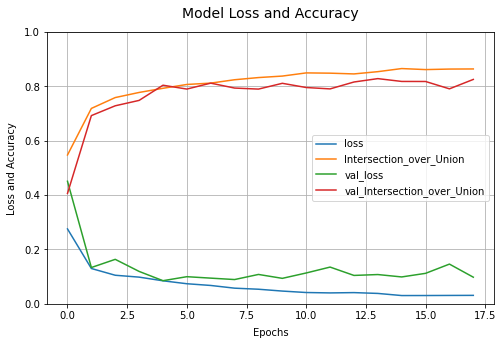

In [160]:
#save the model
name='CNN_Unet_onlyflip_exponentialdecay__2loss_2round'
#os.mkdir('models/')
if  os.path.exists(os.path.join(os.getcwd(),'models/'))==False:
    os.mkdir('models/')
model.save(os.path.join('models/',name+'.h5'))
model.save_weights(os.path.join('models/',name+'_weights.h5'))
#plt.gca().set_xlim(0,33)
   
    
if  os.path.exists(os.path.join(os.getcwd(),'plots/'))==False:
    os.mkdir('plots/')


            
pd.DataFrame(history2.history).plot(figsize=(8, 5))

plt.title('Model Loss and Accuracy',fontsize=14,y=1.03 )
plt.grid( True )    

plt.ylabel('Loss and Accuracy',labelpad=7,fontsize=10)    
plt.xlabel('Epochs',labelpad=7,fontsize=10)   
plt.gca().set_ylim(0,1)
plt.savefig(os.path.join('plots/',name+'.png'), dpi=500, bbox_inches='tight',facecolor=(1, 1, 1) )

#evaluate loss and accuracy
loss, accuracy = model.evaluate(X_val2,y_val2)
#plot loss and accuracy

#plt.gca().set_ylim(0,1)
#plt.grid(True)
if  os.path.exists(os.path.join(os.getcwd(),'models/details'))==False:
    os.mkdir('models/details')
with open(os.path.join('models/details',name+'.txt'), 'w+') as f:
    f.write(f'{name} \n  \n ')
    f.write(f'accuracy : {round(accuracy*100,4)} \n loss : {round(loss,4)}  \n ')
    f.write(f' \n optimizer: \n {model.optimizer.get_config()}')



#print accuracy    
print('Accuracy: %f' % (accuracy*100),'Loss: %f' % (loss))

In [104]:
with open("X_train2", "wb") as f:
    pickle.dump(X_train2, f)
with open("X_val2", "wb") as f:
    pickle.dump(X_val2, f)
with open("y_train2", "wb") as f:
    pickle.dump(y_train2, f)
with open("y_val2", "wb") as f:
    pickle.dump(y_val2, f)
    

In [118]:
preds_test2 = model.predict(X_test, verbose=1)

563/563 [==============================] - 20s 35ms/step


In [119]:
with open("preds_test2", "wb") as f:
    pickle.dump(preds_test2, f)

In [ ]:
confident_y_test2=np.array([])
threshold=1600
def BinaryCrossEntropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    term_0 = (1-y_true) * np.log(1-y_pred + 1e-7)
    term_1 = y_true * np.log(y_pred + 1e-7)
    return -np.mean(term_0+term_1, axis=0)
for i,elem in enumerate(preds_test2):
    confidence=BinaryCrossEntropy(X_test[i].flatten()
                                  ,preds_test[i].flatten())
    if confidence>=threshold:
        #confident_X_test1=np.append(confident_X_test1,X_test[i])
        confident_y_test1=np.append(confident_y_test1,preds_test[i])
        #print(confidence)

In [ ]:
confident_y_test1=np.array([])
threshold=1600
def BinaryCrossEntropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    term_0 = (1-y_true) * np.log(1-y_pred + 1e-7)
    term_1 = y_true * np.log(y_pred + 1e-7)
    return -np.mean(term_0+term_1, axis=0)
for i,elem in enumerate(preds_test):
    confidence=BinaryCrossEntropy(X_test[i].flatten()
                                  ,preds_test[i].flatten())
    if confidence>=threshold:
        #confident_X_test1=np.append(confident_X_test1,X_test[i])
        confident_y_test1=np.append(confident_y_test1,preds_test[i])
        #print(confidence)

In [9]:
im_width = 128
im_height = 128
im_chan = 1
path_test = r'C:\\Users\diego\OneDrive\Desktop\DS\seismic_segmentation\test'
test_ids = next(os.walk(os.path.join(path_test,"images")))[2]  

In [10]:
# Get and resize test images
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    path = path_test
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_test[n] = x

print('Done!')

Getting and resizing test images ... 


<ipython-input-10-80c5a58b954f>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):


  0%|          | 0/18000 [00:00<?, ?it/s]

Done!


In [60]:
preds_test_3stage = model.predict(X_test, verbose=1)
#with open("preds_test2_8_ensemble", "wb") as f:
    #pickle.dump(preds_test, f)

#preds_test = np.round_(preds_test, decimals = 3)

563/563 [==============================] - 36s 54ms/step


In [28]:
#preds_test2_5 = model5.predict(X_test, verbose=1)
#with open("preds_test2_5_ensemble", "wb") as f:
  #  pickle.dump(preds_test2_5, f)

563/563 [==============================] - 23s 36ms/step


In [17]:

with open("preds_test_stage3_ensemble", "wb") as f:
    pickle.dump(preds_test_stage3, f)

563/563 [==============================] - 20s 36ms/step


In [27]:
preds_test_stage3_2 = model2.predict(X_test, verbose=1)
with open("preds_test_stage3_2model", "wb") as f:
    pickle.dump(preds_test_stage3_2, f)

563/563 [==============================] - 120s 211ms/step


In [30]:
'''
with open('preds_test_8ensemble', "rb") as f:
    stage1_predictions=pickle.load(f)
#with open("preds_test2_8_4_ensemble", "rb") as f:
    #ensemble_4=pickle.load(f)
with open('preds_test2_2_ensemble', "rb") as f:
    pred1=pickle.load(f)    
with open('preds_test2_3_ensemble', "rb") as f:
    pred2=stage1_predictions=pickle.load(f)
with open('preds_test2_8_ensemble', "rb") as f:
    pred3=pickle.load(f)    

results=(preds_test2_4+stage1_predictions+pred1+pred2+pred3+preds_test2_5)/6
'''

In [28]:
with open('preds_test_best_submission', "rb") as f:
    pred_ensemble=pickle.load(f) 
results=(pred_ensemble+preds_test_stage3+preds_test_stage3_2)/3

In [15]:
stage1_predictions.shape

(18000, 128, 128, 1)

In [33]:
#save best
with open("preds_test_best_submission", "wb") as f:
    pickle.dump(results, f)

In [29]:
# Create list of upsampled test masks
preds_test_upsampled = []
preds_test=results
for i in tnrange(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

<ipython-input-29-6d843828a469>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(len(preds_test)):


  0%|          | 0/18000 [00:00<?, ?it/s]

In [30]:
preds_test_upsampled[0].shape

(101, 101)

In [31]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i,fn in tqdm_notebook(enumerate(test_ids))}

<ipython-input-31-6ceb950ee2b3>:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i,fn in tqdm_notebook(enumerate(test_ids))}


0it [00:00, ?it/s]

In [32]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission_3stage_withpreviousensemble_2.csv')